# Fake News Detection

Individual project in pairs completed by Scott Pan and Federico Loguercio

With autocratic leaders getting to power in several countries, fake news are becoming an increasingly frequent problem. In most cases, human checking of these news is both unfeasible and inaccurate. In the following notebook we develop a model capable of correctly classifying fake and real news over 94% of the time.

The procedure will be as follows:

First, we begin with some exploratory data analysis to get a feel for the data we are working with

Then, a baseline will be fit. Subsequently, different models will be fit, exploring several different iterations. These include various steps of preprocessing (such as stemming and lemmatizing), the use of different vectorizers (count and tfidf), as well as feature engineering (occurence of elements such as a date or the word "Trump").

Import libraries

In [89]:
import nltk
import numpy as np
import pandas as pd
import helpers as hp
import seaborn as sns
from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet as swn
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from nltk import word_tokenize, WordPunctTokenizer, pos_tag
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

Read the data

In [90]:
train = pd.read_csv('../data/fake_or_real_news_training.csv')
# the submission data has no label
submission = pd.read_csv('../data/fake_or_real_news_test.csv')

Set initial values

In [91]:
# These will be used throughout some functions and can be modified easily.
TARGET_VARIABLE = 'label'
METRIC = 'accuracy'
SEED = 123
TIMESERIES = False
SPLITS = 5

First look at data

In [92]:
train.head()

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


We can see that two extra columns were created, X1 and X2. This is due to the fact that the title is not in quotes such that, if there is a comma in the title, it get's separated at that point and all the other column get shifted. The following cell will take care of that

In [93]:
train = hp.rearrange(train)

In [94]:
train.head()

,ID,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


## EDA

Let's see some key distribution metrics of our dataset

Proportion of fake-news:

In [95]:
len(train.loc[train['label'] == 'FAKE'])/len(train)

0.4978744686171543

Explore text length

Text(0.5, 1.0, 'Distribution of Text length')

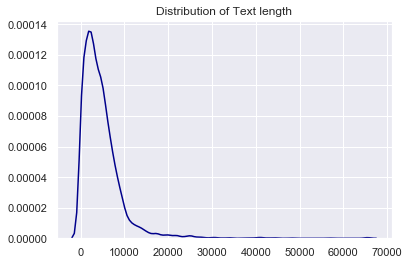

In [96]:
text_len = pd.DataFrame([len(t) for t in train.text])
sns.set()
sns.distplot(text_len, hist = False, color = "darkblue").set_title("Distribution of Text length")

The distribution is highly skewed to the right, there are some very long texts but most lie between 0 and 10000.

## Baseline

Run a baseline without further preprocessing using the countvectorizer. Only the text will be used for now, the title will not be considered yet.

Initiate scores-dataframe that will track scores, using one of the helper functions

In [97]:
all_scores  = pd.DataFrame(columns = ['Model', 'CV Score avg', 'CV Score max', 'Holdout Score'])

Count-vectorize data:

Split data into train and test internally, in order to be able to evaluate how the model will perform on an unseen dataset. Throughout modelling, transformations will be learned on the train set and applied on the test set (as done below with the vectorizer). Within the train set, we will use cross validation. A gap between CV-performance and test performance will indicate over/underfitting.

In [98]:
# split data
def split_data(data, feature='text', random_state = 7):
    X_train, X_test, y_train, y_test = train_test_split(data[feature], data['label'],
                                                        test_size = 0.2, random_state = random_state)
    return X_train, X_test, y_train, y_test

In [99]:
X_baseline, X_test_baseline, y_baseline, y_test_baseline = split_data(train)

In [100]:
# Initiaulize countvectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform 
count_train = count_vectorizer.fit_transform(X_baseline) 

# Transform the test set 
count_test = count_vectorizer.transform(X_test_baseline)

Use Naive Bayes for a first classification

In [101]:
MltNB = MultinomialNB() 

cv_score_baseline, test_score_baseline = hp.cv_evaluate(count_train, y_baseline, count_test, y_test_baseline,
                                                     MltNB)
all_scores = hp.append_scores(all_scores, 'baseline', cv_score_baseline, test_score_baseline)
all_scores

col_0  FAKE  REAL
label            
FAKE    348    57
REAL     27   368


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.895


It seems fairly easy to classify a good amount of the news correctly. Nevertheless, we can see that the model performs worse on the fake news than on the worse news, recall is somewhat lower.

## Preprocess Data

Some standard preprocessing will be applied in order to evaluate whether that improves model performance.
At this stage, that includes: turning all words to lowercase and creating a "word" indicating whether a text contains dates.

In [102]:
train.head()

,ID,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [103]:
train_1 = hp.prepare_data(train, lower = True, date = True)
train_1.head()

,ID,title,text,label
0,8476,you can smell hillary ’ s fear,"daniel greenfield , a shillman journalism fell...",0
1,10294,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,0
2,3608,kerry to go to paris in gesture of sympathy,u.s. secretary of state john f. kerry said mon...,1
3,10142,bernie supporters on twitter erupt in anger ag...,"— kaydee king ( @ kaydeeking ) november 9 , 20...",0
4,875,the battle of new york : why this primary matters,it 's primary day in new york and front-runner...,1


In [104]:
# vectorize
def vectorize_select(selection="tfidf", max_df=0.8, min_df=1, lowercase = True):
    """
    "tfidf":"TfidVectorizer"
    "count":"CountVectorizer"
    "hash":"HashingVectorizer"
    """
    if selection == "tfidf":
        return TfidfVectorizer(stop_words='english', max_df=max_df, min_df=min_df,binary=True,
                              lowercase=lowercase)
    elif selection == "count":
        return CountVectorizer(stop_words='english', max_df=max_df, min_df=min_df)
    elif selection == "hash":
        return HashingVectorizer(stop_words='english')
    else:
        raise Exception("{} can't be found".format(selection))

#### Naive Bayes

With the slightly preprocessed data, let's try different vectorizers (tfidf, count)

In [105]:
# ti-idf vectorize MultinomialNB model
def nb_model(data, selection='tfidf', vectorize_max_df=0.8):
    # split data
    X_train, X_test, y_train, y_test = split_data(data)
    
    # vectorizer: selection: 'tfidf','count','hash'
    vectorizer = vectorize_select(selection, max_df=vectorize_max_df)
    # transform data
    vectorize_train = vectorizer.fit_transform(X_train)
    vectorize_test = vectorizer.transform(X_test)

    # model
    model = MultinomialNB(alpha=0.1)
    cv_scores = cross_val_score(model,
                                vectorize_train,
                                y_train,
                                cv = 5)
    model.fit(vectorize_train, y_train)
    pred = model.predict(vectorize_test)
    acc = accuracy_score(y_test, pred)
    
    #print("accuracy:   %0.3f" % acc)
    print(pd.crosstab(y_test, pred))
    
    return MltNB, cv_scores, acc

In [106]:
for vect in ['count', 'tfidf']:
    print("Fitting Naive Bayes with " + vect + " vectorizer...")
    
    model_temp, cv_scores_temp, test_score_temp = nb_model(train_1, vect, 0.8)
    all_scores = hp.append_scores(all_scores, 'NB ' + vect, cv_scores_temp, test_score_temp)
    
all_scores

Fitting Naive Bayes with count vectorizer...
col_0    0    1
label          
0      352   53
1       28  367
Fitting Naive Bayes with tfidf vectorizer...
col_0    0    1
label          
0      345   60
1       15  380


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,NB count,0.883401,0.903276,0.89875
2,NB tfidf,0.884020,0.915757,0.90625


Turning all to lowercase and creating the date-variable improved the model slightly.

### Vary the model

#### Random Forest

In [107]:
# ti-idf vectorize rf model
def rf_model(data,selection='tfidf',vectorize_max_df=0.8):
    # split data
    X_train, X_test, y_train, y_test = split_data(data)
    
    # vectorizer: selection: 'tfidf','count','hash'
    vectorizer = vectorize_select(selection, max_df=vectorize_max_df)
    # transform data
    vectorize_train = vectorizer.fit_transform(X_train)
    vectorize_test = vectorizer.transform(X_test)
    
    # pipeline
    estimators = [('RF',RandomForestClassifier(random_state=666,n_estimators=100,max_depth=20))]
    pipe = Pipeline(estimators)
    # specify a small grid
    param_RF = {'RF__max_depth': [20,25],
                'RF__n_estimators': [100,150]}
    
    # apply the estimators and parameters in pipeline
    gridPipe = GridSearchCV(pipe, param_RF, cv=5, return_train_score=True)
    model = gridPipe.fit(vectorize_train, y_train)

    pred = model.predict(vectorize_test)
    acc = accuracy_score(y_test, pred)
    
    cv_results = gridPipe.cv_results_['mean_test_score']
    
    #print("accuracy:   %0.3f" % acc)
    print(confusion_matrix(y_test, pred, labels=[0, 1]))
    
    return model, cv_results, acc

Fit the random forest classifier with the different vectorizers. Here we also can use the hash vectorizer

In [108]:
for vect in ['count', 'hash', 'tfidf']:
    print("Fitting Random Forest with " + vect + " vectorizer...")
    
    model_temp, cv_scores_temp, test_score_temp = rf_model(train_1, vect, 0.8)
    all_scores = hp.append_scores(all_scores, 'RF ' + vect, cv_scores_temp, test_score_temp)
    
all_scores

Fitting Random Forest with count vectorizer...
[[373  32]
 [ 47 348]]
Fitting Random Forest with hash vectorizer...
[[363  42]
 [ 67 328]]
Fitting Random Forest with tfidf vectorizer...
[[367  38]
 [ 41 354]]


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,NB count,0.883401,0.903276,0.89875
2,NB tfidf,0.884020,0.915757,0.90625
3,RF count,0.860425,0.866833,0.90125
4,RF hash,0.828384,0.830259,0.86375
5,RF tfidf,0.854720,0.856518,0.90125


Overall, the performance of the Random Forest is better than that of Naive Bayes.

#### Passive Aggressive Classifier

The main idea behind how the passive aggresive classifier works is: As long as it classifies correctly, keep the model (passive). When it misclassifies a sample, it readjusts the model (aggressive).

In [109]:
def PAC(data, selection='tfidf', vectorize_max_df=0.8, feature='text', lowercase = True):
    # split data
    X_train, X_test, y_train, y_test = split_data(data, feature=feature)
    # vectorizer: selection: 'tfidf','count','hash'
    vectorizer = vectorize_select(selection, max_df=vectorize_max_df, lowercase = lowercase)
    # transform data
    vectorize_train = vectorizer.fit_transform(X_train)
    vectorize_test = vectorizer.transform(X_test)
    # model 
    linear_clf = PassiveAggressiveClassifier(random_state=666, max_iter=100, tol=1e-3,
                                             early_stopping=True, validation_fraction=0.1)
    
    clf_cv_scores = cross_val_score(linear_clf,
                                vectorize_train,
                                y_train,
                                cv = 5)
    linear_clf.fit(vectorize_train, y_train)
    pred = linear_clf.predict(vectorize_test)
    acc = accuracy_score(y_test, pred)
    
    #print("accuracy:   %0.3f" % acc)
    print(confusion_matrix(y_test, pred, labels=[0, 1]))
    
    return linear_clf, vectorizer, clf_cv_scores, acc

First, use PAC on the text using the different vectorizers:

In [110]:
for vect in ['count', 'hash', 'tfidf']:
    print("Fitting Passive Aggresive Classifier with " + vect + " vectorizer...")
    
    model_temp, vect_temp, cv_scores_temp, test_score_temp = PAC(train_1, vect)
    all_scores = hp.append_scores(all_scores, 'PAC ' + vect, cv_scores_temp, test_score_temp)
    
all_scores

Fitting Passive Aggresive Classifier with count vectorizer...
[[346  59]
 [ 46 349]]
Fitting Passive Aggresive Classifier with hash vectorizer...
[[366  39]
 [ 34 361]]
Fitting Passive Aggresive Classifier with tfidf vectorizer...
[[378  27]
 [ 26 369]]


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,NB count,0.883401,0.903276,0.89875
2,NB tfidf,0.884020,0.915757,0.90625
3,RF count,0.860425,0.866833,0.90125
4,RF hash,0.828384,0.830259,0.86375
5,RF tfidf,0.854720,0.856518,0.90125
6,PAC count,0.882466,0.892019,0.86875
7,PAC hash,0.915908,0.925117,0.90875
8,PAC tfidf,0.927783,0.948518,0.93375


Not only does the PAC run very quickly, the performance also is far higher then any others.

### Model on Title

Does the title contain relevant information to classify news?

Repeat the same but using the title only (and using tfidf only, since it worked significantly better):

In [111]:
m_title, v_title, cv_pac_title, test_pac_title = PAC(train_1, 'tfidf', feature='title')

all_scores = hp.append_scores(all_scores, 'PAC on title tfidf', cv_pac_title, test_pac_title)
all_scores

[[318  87]
 [ 84 311]]


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,NB count,0.883401,0.903276,0.89875
2,NB tfidf,0.884020,0.915757,0.90625
3,RF count,0.860425,0.866833,0.90125
4,RF hash,0.828384,0.830259,0.86375
5,RF tfidf,0.854720,0.856518,0.90125
6,PAC count,0.882466,0.892019,0.86875
7,PAC hash,0.915908,0.925117,0.90875
8,PAC tfidf,0.927783,0.948518,0.93375
9,PAC on title tfidf,0.774299,0.784711,0.78625


The prediction is worse than the one on the text, but the classifier still classifies a considerable fraction of instances correctly.

Since the title is often repeated at the beginning of the text, we will refrain from concatenating text and title. We tried it and it did not improve performance.

## Lemmatize, Postag etc

In this section, we will explore how eliminating stopwords, lemmatizing and using a porter-stemmer affects model performance.

#### Eliminate stopwords:

In [112]:
train_stopwords = hp.preprocess_data(train_1)
m_stopwords, v_stopwords, cv_stopwords, test_stopwords = PAC(train_stopwords, 'tfidf', feature='text_stop')

all_scores = hp.append_scores(all_scores, 'PAC w/o stopwords', cv_stopwords, test_stopwords)
all_scores

[[379  26]
 [ 28 367]]


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,NB count,0.883401,0.903276,0.89875
2,NB tfidf,0.884020,0.915757,0.90625
3,RF count,0.860425,0.866833,0.90125
4,RF hash,0.828384,0.830259,0.86375
5,RF tfidf,0.854720,0.856518,0.90125
6,PAC count,0.882466,0.892019,0.86875
7,PAC hash,0.915908,0.925117,0.90875
8,PAC tfidf,0.927783,0.948518,0.93375
9,PAC on title tfidf,0.774299,0.784711,0.78625


The scores are very similar to the previous PAC scores using tfidf.

#### Porter Stemmer

For many words, there are several different conjugations and forms which however all share the same stem. For example, fish, fished, and fishing all refer to similar things. The porter stemmer will them all all of them down to fish, making them represent the same stem.

In [113]:
train_porter = hp.preprocess_data(train_1, port = True)
m_port, v_port, cv_port, test_port = PAC(train_porter, 'tfidf', feature='text_port')

all_scores = hp.append_scores(all_scores, 'PAC w/ porter stemmer', cv_port, test_port)
all_scores

[[315  90]
 [ 93 302]]


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,NB count,0.883401,0.903276,0.89875
2,NB tfidf,0.884020,0.915757,0.90625
3,RF count,0.860425,0.866833,0.90125
4,RF hash,0.828384,0.830259,0.86375
5,RF tfidf,0.854720,0.856518,0.90125
6,PAC count,0.882466,0.892019,0.86875
7,PAC hash,0.915908,0.925117,0.90875
8,PAC tfidf,0.927783,0.948518,0.93375
9,PAC on title tfidf,0.774299,0.784711,0.78625


Performance is very bad. Indeed, stemming is not very sophisticated in the sense that it will also group together words which may have completely different meanings.

#### Lemmatize words:

By performing lemmatizing, words belonging to the same family will be grouped to the same lemma. This is similar to stemming but more sophisticated. For example, good, better, best will all be turned into good. This reduces unwanted variation in wording of the same thing, but it could also mask crucial information for fake-news detection.

In [114]:
train_lemma = hp.preprocess_data(train_1, lemmatize = True)
m_lemma, v_lemma, cv_lemma, test_lemma = PAC(train_lemma, 'tfidf', feature='text_lem')

all_scores = hp.append_scores(all_scores, 'PAC w/ lemmatizer', cv_lemma, test_lemma)
all_scores

[[374  31]
 [ 27 368]]


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,NB count,0.883401,0.903276,0.89875
2,NB tfidf,0.884020,0.915757,0.90625
3,RF count,0.860425,0.866833,0.90125
4,RF hash,0.828384,0.830259,0.86375
5,RF tfidf,0.854720,0.856518,0.90125
6,PAC count,0.882466,0.892019,0.86875
7,PAC hash,0.915908,0.925117,0.90875
8,PAC tfidf,0.927783,0.948518,0.93375
9,PAC on title tfidf,0.774299,0.784711,0.78625


Performance is clearly reduced. The different forms of a lemma appear to contain information that helps classifying news. Perhaps, for example, superlatives are more widely used in fake news than in real ones.

For this task, it seems to be better the less the data is processed, as little nuances in spelling and word choice contain valuable information.

## Feature Engineering

Here, we will approach the task in a different way and just try to create some features that could drive whether an article is fake news

Create a dataframe containing several other features and predict using that dataframe.

The feature engineering creates the following features::
- whether the word 'Trump' appears
- length of text and title
- counts of the various pos-tags

In [115]:
train_2 = hp.create_features(train_1)
train_3 = train_2[['label','trump_title', 'trump_text',
                   'title_NN_count', 'title_VERB_count','title_ADJ_count', 
                   'text_NN_count', 'text_VERB_count','text_ADJ_count', 
                   'title_length', 'text_length']]

In [116]:
train_3.head()

,label,trump_title,trump_text,title_NN_count,title_VERB_count,title_ADJ_count,text_NN_count,text_VERB_count,text_ADJ_count,title_length,text_length
0,0,0,1,10,0,0,2776,0,0,7,1474
1,0,1,1,38,0,0,988,0,0,16,517
2,1,0,0,21,0,0,960,0,0,9,486
3,0,0,1,34,0,0,1064,0,0,18,498
4,1,0,1,19,0,0,670,0,0,10,377


We will now fit a normal model using these features

In [117]:
# ti-idf vectorizer rf model
def rf_model_standard(data,features):
    # split data
    X_train, X_test, y_train, y_test = split_data(data,feature=features)
    
    # pipeline
    estimators = [('RF',RandomForestClassifier(random_state=666))]
    pipe = Pipeline(estimators)
    param_RF = {'RF__max_depth': [20,25],
                'RF__n_estimators': [150,200]}
    
    # apply the estimators and parameters in pipeline
    gridPipe = GridSearchCV(pipe, param_RF, cv=5, return_train_score=True)
    model = gridPipe.fit(X_train, y_train)

    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % acc)
    print(confusion_matrix(y_test, pred, labels=[0, 1]))

    return model

In [118]:
features = ['trump_title', 'trump_text',
             'title_NN_count', 'title_VERB_count','title_ADJ_count', 
             'text_NN_count', 'text_VERB_count','text_ADJ_count', 
             'title_length', 'text_length'
           ]
m = rf_model_standard(train_3,features)

accuracy:   0.674
[[259 146]
 [115 280]]


Model performance is very low. The standard NLP approach clearly works better.

### Less processing

In fake news, wrongs spellings and weird conjugations could give us a hint on whether an article is telling the truth. Thus, it is worth it to try fitting a model with the PAC where we do not turn everything to lowercase.

In [119]:
# reload data
train_0 = pd.read_csv('../data/fake_or_real_news_training.csv')
# reprepare data
train_4 = hp.prepare_data(train_0)

In [120]:
m_pac_lowercase, v_pac_not_lowercase, cv_pac_not_lowercase, test_pac_not_lowercase = PAC(train_4,feature='text', lowercase = False)

all_scores = hp.append_scores(all_scores, 'PAC not lowercase', cv_pac_not_lowercase, test_pac_not_lowercase)
all_scores

[[383  22]
 [ 15 380]]


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,NB count,0.883401,0.903276,0.89875
2,NB tfidf,0.884020,0.915757,0.90625
3,RF count,0.860425,0.866833,0.90125
4,RF hash,0.828384,0.830259,0.86375
5,RF tfidf,0.854720,0.856518,0.90125
6,PAC count,0.882466,0.892019,0.86875
7,PAC hash,0.915908,0.925117,0.90875
8,PAC tfidf,0.927783,0.948518,0.93375
9,PAC on title tfidf,0.774299,0.784711,0.78625


Indeed, upper- and lower cases contain information valuable for classifying an article as fake or real.

### Gridsearch

Keeping this non-lowercase configuration, we run a gridsearch in order to find the best hyperparameters.

We are tuning the following elements (all within the vectorizer):
- max_df: ignore very frequent words, conceptually similar to eliminating stopwords (tune the max. frequency)
- min_df: ignore very infrequent words (tune minimum number of occurences). Very infrequent words will tend to lead to overfitting, as they likely will not be found in most texts, reducing generalization power
- ngram: group words together to n-grams (tuning n). In certain cases, a group of words if more informative than words by themselves. For example, "fucking" followed by "awesome" has a very different meaning from the two words by themselves

In [121]:
# passive aggressive classifier with grid search cv
def PAC_NGRAM(data, selection='tfidf', feature='text'):
    # split data
    X_train, X_test, y_train, y_test = split_data(data, feature=feature, random_state=666)
    estimators = [   
                    ('TF',TfidfVectorizer(stop_words='english', binary=True, lowercase=False,
                                         norm='l2',sublinear_tf=False)
                    ),
                    ('PA',PassiveAggressiveClassifier(random_state=666, max_iter=1000, 
                                                      n_iter_no_change=10, tol=1e-3, 
                                                      early_stopping=True, loss='squared_hinge',
                                                      fit_intercept= False,
                                                      validation_fraction=0.1))
                ]
    pipe = Pipeline(estimators)
    param_RF = {
                'TF__max_df':[0.7, 0.8, 0.9],
                'TF__min_df':[3,4,5,6],
                'TF__ngram_range': [(1,1),(1,2),(1,3),(1,4),(3,4),(4,4)]
                }
    
    # apply the estimators and parameters in pipeline
    gridPipe = GridSearchCV(pipe, param_RF, cv=5, return_train_score=True)
    model = gridPipe.fit(X_train, y_train)

    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % acc)
    print(confusion_matrix(y_test, pred, labels=[0, 1]))

    return model

In [123]:
PAC_N = PAC_NGRAM(train_4,feature='text')

accuracy:   0.953
[[379  20]
 [ 18 383]]


In [124]:
PAC_N.best_params_

{'TF__max_df': 0.7, 'TF__min_df': 4, 'TF__ngram_range': (1, 4)}

Use best parameters

In [125]:
def PAC_tuned(data, feature='text'):
    # split data
    X_train, X_test, y_train, y_test = split_data(data, feature=feature)

    vectorizer = TfidfVectorizer(stop_words='english',max_df=0.7, min_df = 4,
                                 binary=True, lowercase=False, ngram_range = (1, 4),
                                 norm='l2',sublinear_tf=False)
    # transform data
    vectorize_train = vectorizer.fit_transform(X_train)
    vectorize_test = vectorizer.transform(X_test)
    # model 
    linear_clf = PassiveAggressiveClassifier(random_state=666, max_iter=100, tol=1e-3,
                                             early_stopping=True, validation_fraction=0.1)
    
    clf_cv_scores = cross_val_score(linear_clf,
                                vectorize_train,
                                y_train,
                                cv = 5)
    linear_clf.fit(vectorize_train, y_train)
    pred = linear_clf.predict(vectorize_test)
    acc = accuracy_score(y_test, pred)
    
    #print("accuracy:   %0.3f" % acc)
    print(confusion_matrix(y_test, pred, labels=[0, 1]))
    
    return linear_clf, clf_cv_scores, acc

In [126]:
PAC_N, cv_pact, test_pact = PAC_tuned(train_4,feature='text')

all_scores = hp.append_scores(all_scores, 'PAC Tuned', cv_pact, test_pact)
all_scores

[[386  19]
 [ 20 375]]


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,NB count,0.883401,0.903276,0.89875
2,NB tfidf,0.884020,0.915757,0.90625
3,RF count,0.860425,0.866833,0.90125
4,RF hash,0.828384,0.830259,0.86375
5,RF tfidf,0.854720,0.856518,0.90125
6,PAC count,0.882466,0.892019,0.86875
7,PAC hash,0.915908,0.925117,0.90875
8,PAC tfidf,0.927783,0.948518,0.93375
9,PAC on title tfidf,0.774299,0.784711,0.78625


## Final Submission

Retrain the best model on the entire data and predict on the submission set

In [127]:
# passive aggressive classifier with grid search cv
def PAC_FINAL(data, selection='tfidf', vectorize_max_df=0.7, vectorize_min_df=4, feature='text'):
    # split data
    X_train = data['text']
    y_train = data['label']
    estimators = [   
                    ('TF',TfidfVectorizer(stop_words='english', binary=True, lowercase=False,
                                          max_df=vectorize_max_df, min_df=vectorize_min_df,
                                         norm='l2',sublinear_tf=False, ngram_range = (1, 4))
                    ),
                    ('PA',PassiveAggressiveClassifier(random_state=666, max_iter=1000, 
                                                      n_iter_no_change=10, tol=1e-3, 
                                                      early_stopping=True, loss='squared_hinge',
                                                      fit_intercept= False,
                                                      validation_fraction=0.1))
                ]
    pipe = Pipeline(estimators)
    param_RF = {
                'PA__C': [1]
                }
    
    # apply the estimators and parameters in pipeline
    gridPipe = GridSearchCV(pipe, param_RF, cv=5, return_train_score=True)
    model = gridPipe.fit(X_train, y_train)

#     pred = model.predict(X_test)
#     acc = accuracy_score(y_test, pred)
#     cv_results = gridPipe.cv_results_['mean_test_score']
#     print("accuracy:   %0.3f" % acc)
#     print(confusion_matrix(y_test, pred, labels=[0, 1]))
    
    return model

In [128]:
m2 = PAC_FINAL(train_4, feature='text')

In [129]:
#submission = pd.read_csv('../data/fake_or_real_news_test.csv')

In [130]:
# Slight modifications to the preparation-function
# because the submission data has a slightly different structure

# m2 is the model from the PAC function
# to apply the same process on submiss
submission['prediction'] = m2.predict(submission['text'])
submission.prediction[submission.prediction==0] = 'FAKE'
submission.prediction[submission.prediction==1] = 'REAL'
#submission = submission.set_index('ID')

# answer is the dataset from kaggle
# this is the dataset downloaded from kaggle so I didn't put it inside the repo
answer = pd.read_csv('../../fake_or_real_news.csv')
answer.rename(columns={'id':'ID'}, inplace=True)
#answer = answer.set_index('ID')

# left join on submission with prediction
submission2 = submission.merge(answer[['ID','label']], how='left', on = "ID")

# metrics
acc = accuracy_score(submission2.label, submission2.prediction)
print("accuracy:   %0.3f" % acc)
print(confusion_matrix(submission2.label, submission2.prediction, labels=['FAKE', 'REAL']))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


accuracy:   0.956
[[1099   65]
 [  37 1120]]
